In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
RECALCULATE = False
PRINT = False

In [3]:
if not os.path.isfile('cache/gender_devtype.pq') or RECALCULATE:
    full_df = pd.read_parquet('../data/SO_2014_2022.pq')
    devtypes = list(full_df['DevType'].dropna().apply(lambda s: s.split(';')[0]).unique())
    dt_series = full_df.DevType.apply(lambda s: s.split(';') if isinstance(s, str) else np.nan)
    dt_mean_sal = pd.DataFrame(columns=['Salary'], index=devtypes)
    dt_gender_count = pd.DataFrame(columns=['Male', 'Female'], index=devtypes)
    dt_gender_sal = pd.DataFrame(columns=['Male', 'Female'], index=devtypes)

    devtype = None


    # Loop closure
    def filter_devtype(types: list, value):
        if devtype not in types:
            return np.nan
        return value


    search_mean_sal = pd.concat([dt_series, full_df.Salary], axis=1).dropna()
    search_gender_count = pd.concat([dt_series, full_df.Gender], axis=1).dropna()
    search_gender_sal = pd.concat([dt_series, full_df.Salary, full_df.Gender], axis=1).dropna()
    for progress, devtype in enumerate(devtypes):
        if PRINT:
            print(f'{progress / len(devtypes):>4.0%}')
        dt_mean_sal.loc[devtype] = search_mean_sal.DevType.combine(search_mean_sal.Salary, filter_devtype).mean()
        dt_gender_count.loc[devtype] = tuple(
            search_gender_count.DevType.combine(search_gender_count.Gender, filter_devtype).value_counts())
        for gender in ['Male', 'Female']:
            sgs = search_gender_sal.query(f"Gender == '{gender.lower()}'")
            dt_gender_sal.loc[devtype][gender] = sgs.DevType.combine(sgs.Salary, filter_devtype).mean()

    if PRINT:
        print('100%')

    df = pd.DataFrame()
    df['Salary'] = dt_mean_sal['Salary']
    df['MaleCount'] = dt_gender_count['Male']
    df['FemaleCount'] = dt_gender_count['Female']
    df['MaleSalary'] = dt_gender_sal['Male']
    df['FemaleSalary'] = dt_gender_sal['Female']
    df['Gap'] = (df['MaleSalary'] - df['FemaleSalary']) / df['Salary'] * 100
    df['Prop'] = df['MaleCount'] / df['FemaleCount']

    # Some positions might be unreliable due to low female respondent count
    df.query('MaleCount > 200 & FemaleCount > 200', inplace=True)

    df.to_parquet('cache/gender_devtype.pq')
    RECALCULATE = False
else:
    df = pd.read_parquet('cache/gender_devtype.pq')
    if PRINT:
        print('Loaded from cache')

In [4]:
df.head()

,Salary,MaleCount,FemaleCount,MaleSalary,FemaleSalary,Gap,Prop
Data scientist or machine learning specialist,66741.062337,27967,2135,67065.807725,65158.192406,2.858233,13.099297
"Engineer, data",74134.871049,15341,801,73851.015016,75325.595661,-1.989051,19.152310
"Developer, front-end",57962.401026,95441,7128,58357.289909,56208.281881,3.707590,13.389590
Student,24490.338723,34176,2740,24634.515929,24305.919094,1.341741,12.472993
"Developer, full-stack",62865.299330,182772,9983,63024.234952,63244.182031,-0.349870,18.308324


In [8]:
if PRINT:
    print('Positions with most female favourable pay gap:', *df.sort_values(by='Gap').head(3).index.tolist(),
          sep='\n\t')
    print('\nPositions with most male favourable pay gap:',
          *df.sort_values(by='Gap', ascending=False).head(3).index.tolist(), sep='\n\t')
    print('\nPositions with highest female proportion:',
          *df.sort_values(by='Prop', ascending=False).head(3).index.tolist(), sep='\n\t')
    print('\nPositions with lowest female proportion:', *df.sort_values(by='Prop').head(3).index.tolist(), sep='\n\t')

Positions with most female favourable pay gap:
	Engineer, site reliability
	Engineer, data
	Product manager

Positions with most male favourable pay gap:
	Marketing or sales professional
	Developer, QA or test
	Database administrator

Positions with highest female proportion:
	Senior Executive (C-Suite, VP, etc.)
	DevOps specialist
	System administrator

Positions with lowest female proportion:
	Marketing or sales professional
	Student
	Educator or academic


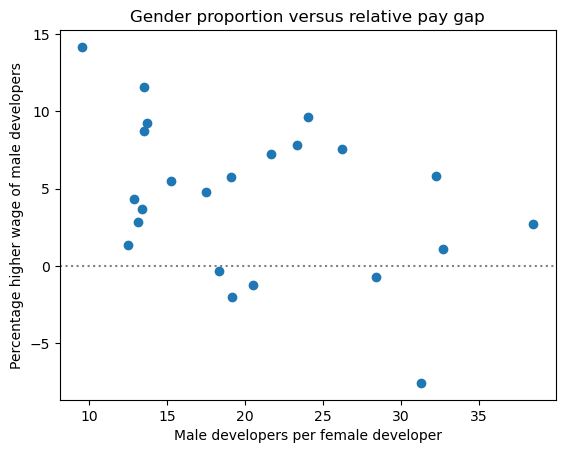

In [6]:
plt.scatter(x=df['Prop'], y=df['Gap'])
SHOW_MEAN = False

if SHOW_MEAN:
    mean_proportion = df.MaleCount.sum() / df.FemaleCount.sum()
    mean_gap = (df.Gap * (df.MaleCount + df.FemaleCount)).sum() / (df.MaleCount.sum() + df.FemaleCount.sum())
    plt.axvline(color='grey', linestyle='dashed', x=mean_proportion)
    plt.axhline(color='grey', linestyle='dashed', y=mean_gap)
    plt.annotate(color='grey', xy=(mean_proportion + 0.5, mean_gap - 1), text='Mean')
else:
    plt.axhline(color='grey', linestyle='dotted')

plt.title('Gender proportion versus relative pay gap')
plt.xlabel('Male developers per female developer')
plt.ylabel('Percentage higher wage of male developers')

plt.show()

# Seems like higher proportion males ~= better pay females